In [1]:
from langgraph.graph import StateGraph, END
from pydantic import BaseModel
from typing import List
from langchain_core.messages import AnyMessage

# ---- Dummy State Model ----
class RAGState(BaseModel):
    messages: List[AnyMessage] = []
    youtube_link: str = ""
    transcription: str = ""
    summarized_context: str = ""
    final_answer: str = ""

# ---- Dummy Nodes ----
def check_url_node(state: RAGState) -> str:
    return "transcribe"  # or "not_transcribe"

def transcribe_node(state: RAGState) -> RAGState:
    return state

def retrieval_node(state: RAGState) -> RAGState:
    return state

def chat_node(state: RAGState) -> RAGState:
    return state

# ---- Build Graph ----
graph_builder = StateGraph(RAGState)

graph_builder.add_node("Check_URL_Node", check_url_node)
graph_builder.add_node("Transcribe_Node", transcribe_node)
graph_builder.add_node("Retrieval_Node", retrieval_node)
graph_builder.add_node("Chat_Node", chat_node)

graph_builder.set_entry_point("Check_URL_Node")

graph_builder.add_conditional_edges(
    source="Check_URL_Node",
    path=check_url_node,
    path_map={
        "transcribe": "Transcribe_Node",
        "not_transcribe": "Retrieval_Node"
    }
)

graph_builder.add_edge("Transcribe_Node", "Retrieval_Node")
graph_builder.add_edge("Retrieval_Node", "Chat_Node")

graph_builder.set_finish_point("Chat_Node")

# ---- Compile without checkpoint/store ----
graph = graph_builder.compile()


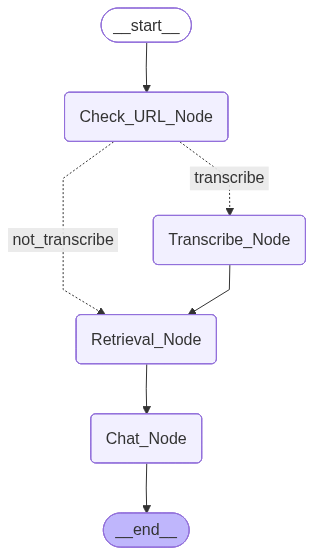

In [2]:
graph

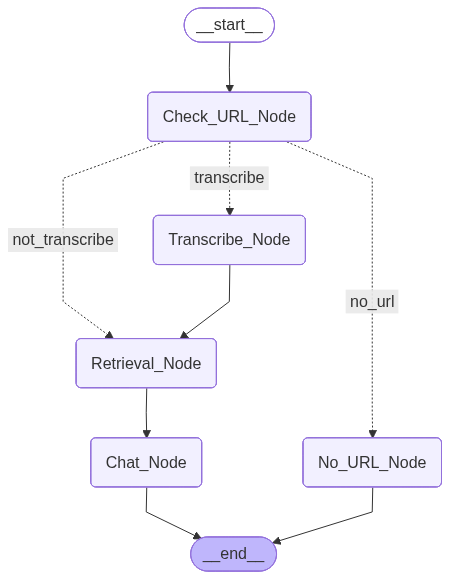

In [1]:
from langgraph.graph import StateGraph
from pydantic import BaseModel
from typing import List

# ---------------------- DUMMY STATE ----------------------
class RAGState(BaseModel):
    messages: List[str] = []
    youtube_link: str = ""
    transcription: str = ""
    retrieved_docs: List[str] = []
    final_answer: str = ""

# ---------------------- DUMMY NODE FUNCTIONS ----------------------
def Check_URL_Node(state):
    print("Checking URL...")
    return "transcribe"  # just return a path for visualization

def No_URL_Node(state):
    print("No URL provided.")
    return state

def Transcribe_Node(state):
    print("Transcribing audio...")
    return state

def Retrieval_Node(state):
    print("Retrieving documents...")
    return state

def Chat_Node(state):
    print("Generating final answer...")
    return state

# ---------------------- GRAPH BUILD ----------------------
# ---------------------- GRAPH BUILD ----------------------
graph_builder = StateGraph(RAGState)

# 1️⃣ Add nodes
graph_builder.add_node("Check_URL_Node", Check_URL_Node)
graph_builder.add_node("No_URL_Node", No_URL_Node)
graph_builder.add_node("Transcribe_Node", Transcribe_Node)
graph_builder.add_node("Retrieval_Node", Retrieval_Node)
graph_builder.add_node("Chat_Node", Chat_Node)

# 2️⃣ Set entry point
graph_builder.set_entry_point("Check_URL_Node")

# 3️⃣ Conditional branching from Check_URL_Node
graph_builder.add_conditional_edges(
    "Check_URL_Node",
    Check_URL_Node,
    {
        "no_url": "No_URL_Node",          # No YouTube URL provided
        "transcribe": "Transcribe_Node",  # New video
        "not_transcribe": "Retrieval_Node",  # Already transcribed
    },
)

# 4️⃣ Linear flow after branching
graph_builder.add_edge("Transcribe_Node", "Retrieval_Node")  # after transcribing, move to retrieval
graph_builder.add_edge("Retrieval_Node", "Chat_Node")        # retrieval always leads to chat

# 5️⃣ Set finish point
graph_builder.set_finish_point("Chat_Node")


# ---------------------- COMPILE & VISUALIZE ----------------------
app = graph_builder.compile()

# To visualize the structur
app


✅ Database connections established & store initialized.


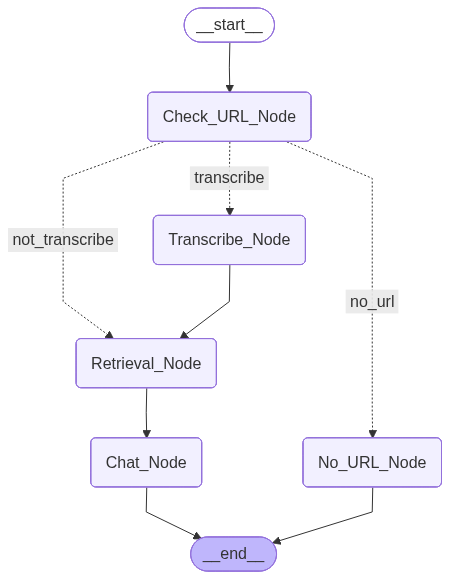

In [3]:
import sys
import os
__file__ = r"d:\Programming\Python in Sublime\LLM Works\LangGraph Basic\Graphs\Youtube Rag Chatbot\show_graph.ipynb"
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))


from typing import List, Annotated
from pydantic import BaseModel
from langchain.schema import Document
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph,add_messages

from langgraph.store.postgres import PostgresStore
from langgraph.store.base import BaseStore

from utils.db import store, checkpointer

from utils.audio import extract_audio
from pipelines.transcription import transcribe_audio

from dotenv import load_dotenv
import os

load_dotenv()

# ---------------------- MODEL SETUP ----------------------
model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    api_key=os.getenv("GOOGLE_API_KEY")
)

prompt_template = ChatPromptTemplate.from_messages([
    ("system", "{system_message}"),
    MessagesPlaceholder("messages")
])

llm_model = prompt_template | model


# ---------------------- RAG STATE ----------------------
from typing import List, Annotated,Optional
from pydantic import BaseModel, Field
from langchain.schema import Document
from langchain_core.messages import AnyMessage


from urllib.parse import urlparse, parse_qs

def get_youtube_video_id(url: str) -> str:
    """
    Extracts the YouTube video ID from a URL.
    Supports:
      - https://www.youtube.com/watch?v=VIDEO_ID
      - https://youtu.be/VIDEO_ID
      - https://www.youtube.com/shorts/VIDEO_ID
    """
    if not url:
        return None

    if "youtu.be" in url:
        return url.split("/")[-1]
    elif "youtube.com" in url:
        parsed = urlparse(url)
        if parsed.path.startswith("/shorts/"):
            return parsed.path.split("/")[2]  # get ID after /shorts/
        query = parse_qs(parsed.query)
        return query.get("v", [None])[0]
    return None


class RAGState(BaseModel):
    """
    Represents the state of a Retrieval-Augmented Generation (RAG) conversation.
    """
    messages: Annotated[List[AnyMessage], add_messages]
    youtube_link: Annotated[Optional[str], Field(default=None, description="YouTube video URL (if provided)")]
    transcription: Annotated[Optional[str], Field(default=None, description="Full transcription of the video")]
    retrieved_docs: Annotated[List[Document], Field(default_factory=list, description="Retrieved document chunks for context")]
    final_answer: Annotated[Optional[str], Field(default=None, description="Final generated response from the LLM")]

# ---------------------- GRAPH NODES ----------------------

def Check_URL_Node(state: RAGState, store: BaseStore,config: RunnableConfig):
    print("Yes".center(100,"*"))
    """
    Checks if this user has already transcribed this YouTube video.
    Returns one of: "no_url", "transcribe", "not_transcribe"
    """
    user_id = config["configurable"]["user_id"]
    # Check URL presence
    if not state.youtube_link or not state.youtube_link.strip():
        return "no_url"

    # Check if transcription already exists
    namespace = (user_id, state.youtube_link)
    try:
        results = store.search(namespace,query="*",filter={"url": state.youtube_link},limit=1)
        print("This is the result ",result)
    except Exception as e:
        print(f"DB search error: {e}")
        results = []

    if results:
        return "not_transcribe"
    else:
        return "transcribe"


def No_URL_Node(state: RAGState, config: RunnableConfig):
    """Handles case where user didn't provide a YouTube URL."""
    state.final_answer = "Please paste a YouTube video link first before asking questions."
    return state


def Transcribe_Node(state: RAGState, store: BaseStore, config: RunnableConfig):
    """Downloads, transcribes, and stores embeddings."""
    user_id = config["configurable"]["user_id"]

    video_id = get_youtube_video_id(state.youtube_link)
    namespace = (user_id, video_id)

    print("This is the Namespace: ",namespace)
    # Step 1: Download audio
    audio_path = extract_audio(state.youtube_link, output_folder="downloaded_audio")

    # Step 2: Transcribe
    state.transcription = transcribe_audio(audio_path)

    # Step 3: Split into chunks
    splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
    chunks = splitter.split_text(state.transcription)

    # Step 4: Store each chunk as embedding
    for i, chunk in enumerate(chunks):
        key = f"chunk_{i+1}"
        metadata = {"text": chunk, "url": state.youtube_link}
        store.put(namespace, key, metadata, index=["text"])
    print("Successfully data put in the db")
    return state


def Retrieval_Node(state: RAGState, store: BaseStore, config: RunnableConfig):
    user_id = config["configurable"]["user_id"]
    namespace = (user_id, get_youtube_video_id(state.youtube_link))

    if not state.messages or not state.messages[-1].content.strip():
        print("No user question provided — skipping retrieval for now.")
        state.retrieved_docs = []
        return state

    query = state.messages[-1].content
    result = store.search(namespace, query=query, limit=3)

    # Wrap text chunks in Document objects
    retrieved = [
        Document(page_content=r.value["text"], metadata={"url": state.youtube_link})
        for r in result
    ] if result else []

    state.retrieved_docs = retrieved
    print(f"🔍 Retrieved {len(retrieved)} relevant chunks for query: {query}")
    return state



def Chat_Node(state: RAGState, store: BaseStore, config: RunnableConfig):
    """
    Generates the final answer using the retrieved context.
    Handles both:
        - User just uploaded a video (no question yet)
        - User asked a question (with context)
    """
    if not state.messages or not state.messages[-1].content.strip():
        state.final_answer = (
            "The video has been successfully transcribed and stored.\n"
            "You can now ask me questions about its content!"
        )
        return state
    context = "\n".join(state.retrieved_docs) if state.retrieved_docs else "No relevant context found."
    system_message = SystemMessage(content=f"You are a helpful tutor. Use this context:\n{context}")

    response = llm_model.invoke({
        "system_message": system_message,
        "messages": [{"role": "user", "content": state.messages[-1].content}],
    })

    state.final_answer = response.content
    return state

# ---------------------- GRAPH BUILD ----------------------
graph_builder = StateGraph(RAGState)


# graph_builder.add_node("Check_URL_Node", Check_URL_Node)
# graph_builder.add_node("No_URL_Node", No_URL_Node)
#    
graph_builder.add_node(node="Check_URL_Node", action= lambda state:state)
graph_builder.add_node(node="No_URL_Node", action= lambda state:state)    
        # <-- move here (before it's referenced)
graph_builder.add_node("Transcribe_Node", Transcribe_Node)
graph_builder.add_node("Retrieval_Node", Retrieval_Node)
graph_builder.add_node("Chat_Node", Chat_Node)


graph_builder.set_entry_point("Check_URL_Node")


graph_builder.add_conditional_edges(
    source="Check_URL_Node",
    path=Check_URL_Node,
    path_map={
        "no_url": "No_URL_Node",
        "transcribe": "Transcribe_Node",
        "not_transcribe": "Retrieval_Node"
    }
)

graph_builder.add_edge("Transcribe_Node", "Retrieval_Node") 
graph_builder.add_edge("Retrieval_Node", "Chat_Node") 

graph_builder.set_finish_point("Chat_Node")

app = graph_builder.compile(checkpointer=checkpointer,store=store)

app